In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import time


np.random.seed(1)

# Little boilerplate code to find out if we have a gpu
device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = 'cuda'
else:
    print("No GPU available!")
print(f'Device: {device}')

Cuda installed! Running on GPU!
Device: cuda


## Seismic Data Denoising

In [2]:
## Loading the shot gathers
import numpy as np
data = np.load('data/Marmousi2_Data/Marmousi2_5hz_Data.npy')
data = np.permute_dims(data,(1,0,2))
data.shape

(30, 1000, 200)

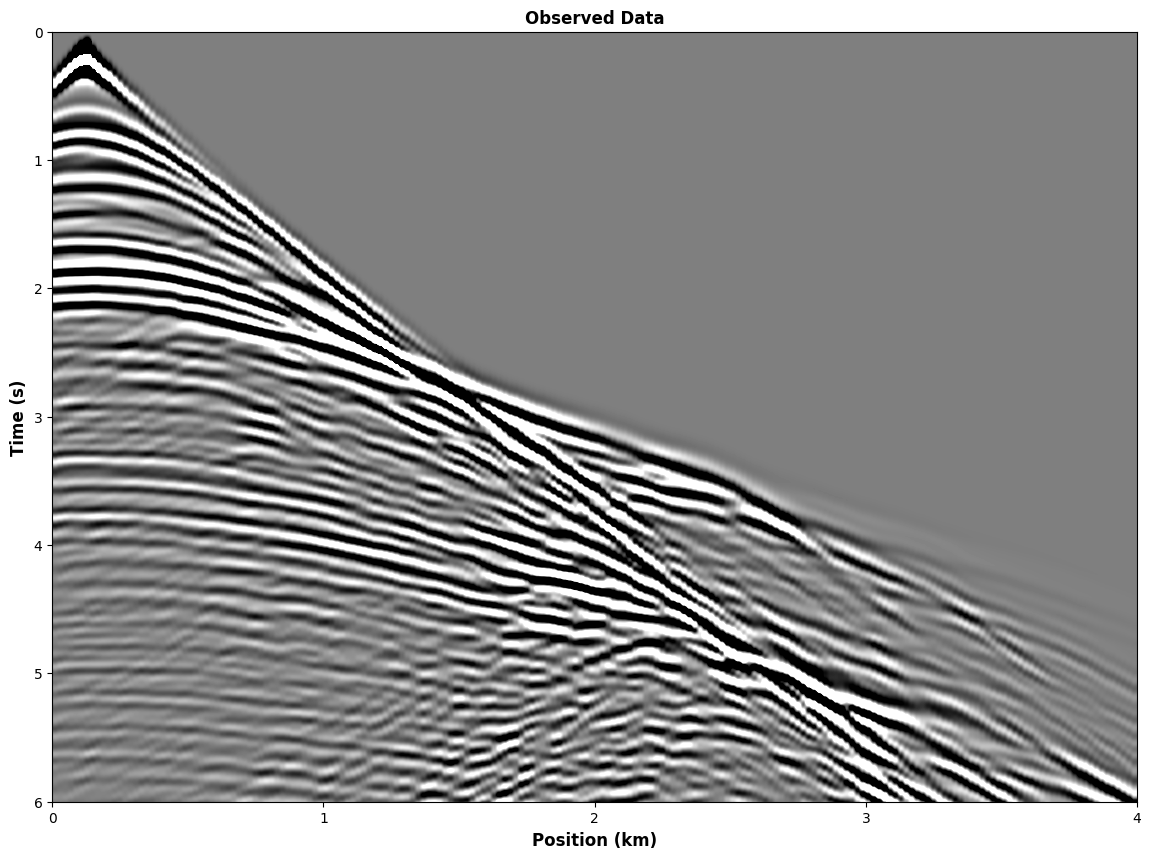

Shot Dimension is: torch.Size([1000, 200])


In [3]:
import torch
from matplotlib.ticker import MaxNLocator

font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 10}
f, ax = plt.subplots(1, 1, figsize=(14, 10), sharey=False)
plt.rc('font', **font)

dx        = 20                  # step interval along x/z direction
dt        = 0.006                 # time interval (e.g., 6ms)
shotnum = 0
selected_shot = torch.tensor(data[shotnum,:,:]).to(device)
vmin, vmax = torch.quantile(selected_shot,
                            torch.tensor([0.05, 0.95]).to(device))

ax.imshow(selected_shot.cpu(), aspect='auto', cmap='gray',
             vmin=vmin, vmax=vmax,
             extent=[0, selected_shot.shape[1] * dx/1000, selected_shot.shape[0] *(dt), 0])

ax.set_xlabel('Position (km)',fontsize='large', fontweight='bold')
ax.set_ylabel('Time (s)',fontsize='large', fontweight='bold')
ax.set_title('Observed Data',fontsize='large', fontweight='bold')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.show()
print('Shot Dimension is:',selected_shot.shape)

## Normalize each shot if you want

In [4]:
data_Normalized = np.zeros_like(data)
for i in range(data.shape[0]):
    data_Normalized[i,:,:] =data[i,:,:]/np.max(np.abs(data[i,:,:]))
    

## Adding Gaussian Noise

In [5]:
import torch

# Small value to prevent division by zero in SNR
epsilon = 1e-10

# Example data with shape (30, 1000, 200)
dat = torch.tensor(data)  # Convert to tensor
num_shots = dat.shape[0]
shots_per_noise_level = 10

# Define different levels of noise (standard deviations)
noise_levels = torch.linspace(0.5, 1, shots_per_noise_level)

# Initialize a list to collect shots with noise and SNR
noisy_shots = []
clean_shots = []
snr_values = []

# Add Gaussian noise to each shot and calculate SNR
for i in range(num_shots):
    for noise_level in noise_levels:
        noise = torch.normal(mean=0.0, std=noise_level, size=dat[i, :, :].shape)
        clean_shot = dat[i, :, :]
        noisy_shot = dat[i, :, :] + noise
        
        # Calculate SNR
        signal_power = torch.mean(dat[i, :, :]**2)  # Power of the signal
        noise_power = torch.mean(noise**2) + epsilon  # Power of the noise with epsilon
        snr = 10 * torch.log10(signal_power / noise_power)  # SNR in dB   
        snr_values.append(snr.item())
        noisy_shots.append(noisy_shot)
        clean_shots.append(clean_shot)

# Convert list to a PyTorch tensor
data_noisy = torch.stack(noisy_shots)
data_clean = torch.stack(clean_shots)

# Check the shape and SNR values
print('The number of noisy data:', data_noisy.shape)  # Shape of the noisy data
print(snr_values[0:10])  # Print the SNR for each noisy shot

The number of noisy data: torch.Size([300, 1000, 200])
[1.0274689197540283, 0.0893092155456543, -0.7487111687660217, -1.4710230827331543, -2.1749110221862793, -2.822159767150879, -3.407276153564453, -3.998039960861206, -4.519813537597656, -4.983885288238525]


## Plotting Noisy Data

/tmp/ipykernel_4169191/832919360.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  selected_shot = torch.tensor(data_noisy[shotnum,:,:]).to(device)
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'no

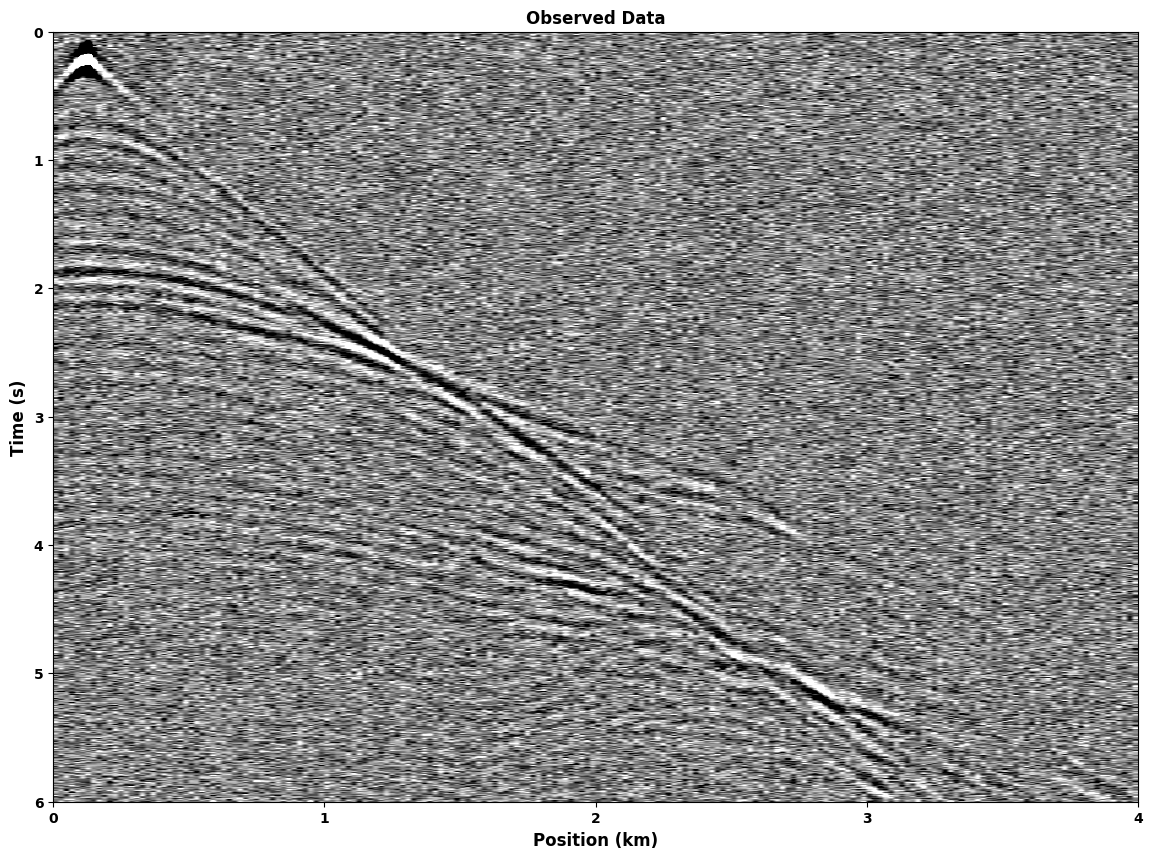

Shot Dimension is: torch.Size([1000, 200])


In [6]:
import torch
from matplotlib.ticker import MaxNLocator

font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 10}
f, ax = plt.subplots(1, 1, figsize=(14, 10), sharey=False)
plt.rc('font', **font)

dx        = 20                  # step interval along x/z direction
dt        = 0.006                 # time interval (e.g., 6ms)
shotnum = 9
selected_shot = torch.tensor(data_noisy[shotnum,:,:]).to(device)
vmin, vmax = torch.quantile(selected_shot,
                            torch.tensor([0.05, 0.95]).to(device))

ax.imshow(selected_shot.cpu(), aspect='auto', cmap='gray',
             vmin=vmin, vmax=vmax,
             extent=[0, selected_shot.shape[1] * dx/1000, selected_shot.shape[0] *(dt), 0])

ax.set_xlabel('Position (km)',fontsize='large', fontweight='bold')
ax.set_ylabel('Time (s)',fontsize='large', fontweight='bold')
ax.set_title('Observed Data',fontsize='large', fontweight='bold')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.show()
print('Shot Dimension is:',selected_shot.shape)

## UNET

In [7]:
import torch
import torch.nn as nn

class UNET(nn.Module):
    def __init__(self, input_channels, FM1, FM2, FM3, bottleneck_dim, output_channels):
        super(UNET, self).__init__()
        
        # Encoder
        self.encoder_conv1 = nn.Conv2d(input_channels, FM1, kernel_size=3, stride=1, padding=1)
        self.encoder_ac1 = nn.LeakyReLU(0.1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.encoder_conv2 = nn.Conv2d(FM1, FM2, kernel_size=3, stride=1, padding=1)  # Same feature maps
        self.encoder_ac2 = nn.LeakyReLU(0.1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.encoder_conv3 = nn.Conv2d(FM2, FM3, kernel_size=3, stride=1, padding=1)
        self.encoder_ac3 = nn.LeakyReLU(0.1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.encoder_bottleneck = nn.Conv2d(FM3, bottleneck_dim, kernel_size=3, stride=1, padding=1)  # Bottleneck with 1 feature map
        self.encoder_bottleneck_ac = nn.LeakyReLU(0.1)

        # Decoder
        self.decoder_upsample1 = nn.Upsample(scale_factor=2, mode='bilinear')
        self.decoder_conv1 = nn.Conv2d(bottleneck_dim, FM3, kernel_size=3, padding=1)
        self.decoder_ac1 = nn.LeakyReLU(0.1)

        self.decoder_upsample2 = nn.Upsample(scale_factor=2, mode='bilinear')
        self.decoder_conv2 = nn.Conv2d(FM3, FM2, kernel_size=3, padding=1)
        self.decoder_ac2 = nn.LeakyReLU(0.1)

        self.decoder_upsample3 = nn.Upsample(scale_factor=2, mode='bilinear')
        self.decoder_conv3 = nn.Conv2d(FM2, FM1, kernel_size=3, padding=1)
        self.decoder_ac3 = nn.LeakyReLU(0.1)

        self.decoder_convF = nn.Conv2d(FM1, output_channels, kernel_size=3, padding=1)  # Final output layer
        #self.decoder_acF = nn.Tanh()

    def forward(self, x):
        # Encoding
        E1 = self.encoder_conv1(x)
        E1 = self.encoder_ac1(E1)
        P1 = self.pool1(E1)

        E2 = self.encoder_conv2(P1)
        E2 = self.encoder_ac2(E2)
        P2 = self.pool2(E2)

        E3 = self.encoder_conv3(P2)
        E3 = self.encoder_ac3(E3)
        P3 = self.pool3(E3)

        # Bottleneck
        E5 = self.encoder_bottleneck(P3)
        E5 = self.encoder_bottleneck_ac(E5)

        # Decoding
        D1 = self.decoder_upsample1(E5)
        D1 = self.decoder_conv1(D1)
        D1 = self.decoder_ac1(D1)
        D1 = D1 + E3  # Skip connection

        D2 = self.decoder_upsample2(D1)
        D2 = self.decoder_conv2(D2)
        D2 = self.decoder_ac2(D2)
        D2 = D2 + E2  # Skip connection

        D3 = self.decoder_upsample3(D2)
        D3 = self.decoder_conv3(D3)
        D3 = self.decoder_ac3(D3)
        D3 = D3 + E1  # Skip connection
        
        out = self.decoder_convF(D3)  # Final output layer
        #out = self.decoder_acF(out)
        
        return E5, out

## Data preparation

In [8]:
from torch.utils.data import Dataset, DataLoader

# 1. Define your Dataset class (if you haven't already):

class MyDataset(Dataset):
    def __init__(self, data, labels):
        self.data = torch.tensor(data, dtype=torch.float32)  # Convert to torch tensor
        self.labels = torch.tensor(labels, dtype=torch.float32) #Convert labels to long for classification

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

In [9]:
from sklearn.model_selection import train_test_split

batch_size = 8
# data and labels to tensor
datainput = torch.tensor(data_noisy,dtype=torch.float32)
labelout = torch.tensor(data_clean,dtype=torch.float32)


# Divide the data into train and test
train_data, test_data, train_labels, test_labels = train_test_split(
    datainput, labelout, test_size=0.1, random_state=42)

# Create your Dataset instance
dataset_train = MyDataset(train_data, train_labels)
dataset_test  = MyDataset(test_data, test_labels)

# Create a DataLoader
# Adjust batch_size as needed; shuffle=True for training

train_loader = torch.utils.data.DataLoader(dataset=dataset_train, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=dataset_test, 
                                          batch_size=batch_size, 
                                          shuffle=False)

/tmp/ipykernel_4169191/1818581508.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  datainput = torch.tensor(data_noisy,dtype=torch.float32)
/tmp/ipykernel_4169191/1818581508.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labelout = torch.tensor(data_clean,dtype=torch.float32)
/tmp/ipykernel_4169191/1364125503.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.data = torch.tensor(data, dtype=torch.float32)  # Convert to torch tensor
/tmp/ipykernel_4169191/1364125503.py:8: UserWarning: To copy construct from a tensor, it is re

In [ ]:

input_channels = 1
FM1 = 128
FM2 = 2*FM1
FM3 = 2*FM2
bottleneck_dim = 2*FM3
output_channels = 1

model = UNET(input_channels, FM1, FM2, FM3, bottleneck_dim, output_channels).to(device)
print(model)


criterion = nn.MSELoss()
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  

# Train the model
model.train()
num_epochs = 100

for epoch in range(num_epochs):
    losall = 0
    for i, (images, labels) in enumerate(train_loader):
        # Load images with gradient accumulation capabilities
        images = images.view(images.shape[0], 1, images.shape[1],images.shape[2]).requires_grad_(True).to(device)
        labels = labels.view(labels.shape[0], 1, labels.shape[1],labels.shape[2]).to(device)

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()
        
        # Forward pass to get output/logits
        E, outputs = model(images)
        
        # Calculate Loss
        loss = criterion(outputs, labels)
        losall+= loss.item()
        
        # Getting gradients w.r.t. parameters
        loss.backward()
        
        # Updating parameters
        optimizer.step()
        
    
            
    # Print Loss
    print('epoch: {}. Loss: {}'.format(epoch, losall))
    


UNET(
  (encoder_conv1): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (encoder_ac1): LeakyReLU(negative_slope=0.1)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder_conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (encoder_ac2): LeakyReLU(negative_slope=0.1)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder_conv3): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (encoder_ac3): LeakyReLU(negative_slope=0.1)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder_bottleneck): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (encoder_bottleneck_ac): LeakyReLU(negative_slope=0.1)
  (decoder_upsample1): Upsample(scale_factor=2.0, mode='bilinear')
  (decoder_conv1): Conv2d(1024, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (decoder_ac1): LeakyReLU(nega

In [ ]:
laball = []
dat = []
outputsall= []
Eall = []
# Iterate through test dataset
for images, labels in test_loader:
    # Load images with gradient accumulation capabilities
    images = images.view(images.shape[0], 1, images.shape[1],images.shape[2]).requires_grad_(True).to(device)
    labels = labels.view(labels.shape[0], 1, labels.shape[1],labels.shape[2]).to(device)


    # Forward pass only to get logits/output
    E, outputs = model(images)

    
    laball.append(labels.cpu().numpy())
    dat.append(images.detach().cpu().numpy())
    outputsall.append(outputs.detach().cpu().numpy())

    

outputsall = np.concatenate(outputsall)
laball = np.concatenate(laball)
dat = np.concatenate(dat)

# Print Loss
print('Loss: {}'.format(loss.item()))

## Plotting the denoised results of the test set

In [ ]:
import torch
from matplotlib.ticker import MaxNLocator

font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 10}
f, ax = plt.subplots(1, 4, figsize=(14, 10), sharey=False)
plt.rc('font', **font)

dx        = 20                  # step interval along x/z direction
dt        = 0.006                 # time interval (e.g., 6ms)
shotnum = 2

# Noisy data (input)
selected_shot = torch.tensor(dat[shotnum,:,:][0,:,:]).to(device)
vmin, vmax = torch.quantile(selected_shot,
                            torch.tensor([0.05, 0.95]).to(device))

ax[0].imshow(selected_shot.cpu(), aspect='auto', cmap='gray',
             vmin=vmin, vmax=vmax,
             extent=[0, selected_shot.shape[1] * dx/1000, selected_shot.shape[0] *(dt), 0])

ax[0].set_xlabel('Position (km)',fontsize='large', fontweight='bold')
ax[0].set_ylabel('Time (s)',fontsize='large', fontweight='bold')
ax[0].set_title('Noisy Data',fontsize='large', fontweight='bold')
ax[0].xaxis.set_major_locator(MaxNLocator(integer=True))

# Denoised data
selected_shot = torch.tensor(outputsall[shotnum,:,:][0,:,:]).to(device)

ax[1].imshow(selected_shot.cpu(), aspect='auto', cmap='gray',
             vmin=vmin, vmax=vmax,
             extent=[0, selected_shot.shape[1] * dx/1000, selected_shot.shape[0] *(dt), 0])

ax[1].set_xlabel('Position (km)',fontsize='large', fontweight='bold')
ax[1].set_ylabel('Time (s)',fontsize='large', fontweight='bold')
ax[1].set_title('Denoised Data',fontsize='large', fontweight='bold')
ax[1].xaxis.set_major_locator(MaxNLocator(integer=True))


# Clean data
selected_shot = torch.tensor(laball[shotnum,:,:][0,:,:]).to(device)

ax[2].imshow(selected_shot.cpu(), aspect='auto', cmap='gray',
             vmin=vmin, vmax=vmax,
             extent=[0, selected_shot.shape[1] * dx/1000, selected_shot.shape[0] *(dt), 0])

ax[2].set_xlabel('Position (km)',fontsize='large', fontweight='bold')
ax[2].set_ylabel('Time (s)',fontsize='large', fontweight='bold')
ax[2].set_title('Clean Data',fontsize='large', fontweight='bold')
ax[2].xaxis.set_major_locator(MaxNLocator(integer=True))

# Error
selected_shot = torch.tensor(outputsall[shotnum,:,:][0,:,:]-laball[shotnum,:,:][0,:,:]).to(device)

ax[3].imshow(selected_shot.cpu(), aspect='auto', cmap='gray',
             vmin=vmin, vmax=vmax,
             extent=[0, selected_shot.shape[1] * dx/1000, selected_shot.shape[0] *(dt), 0])

ax[3].set_xlabel('Position (km)',fontsize='large', fontweight='bold')
ax[3].set_ylabel('Time (s)',fontsize='large', fontweight='bold')
ax[3].set_title('Error',fontsize='large', fontweight='bold')
ax[3].xaxis.set_major_locator(MaxNLocator(integer=True))

plt.show()
